In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import folium

import json

In [3]:
accidents_data_file11 = "data/accidents_2009_to_2011.csv"
accidents_data_file14 = "data/accidents_2012_to_2014.csv"

data1 = pd.read_csv(accidents_data_file11)
data2 = pd.read_csv(accidents_data_file14)

data = pd.concat([data1, data2])


In [6]:
## Create new variables
## For yearly trends
data['Year'] = data['Date'].apply(lambda x : str(x).split("/")[2])
data['Month'] = data['Date'].apply(lambda x : str(x).split("/")[1])
                              
## Co-ordinates of the accident for plotting on map
data["co-ordinates"] = data.apply(lambda x: (x["Latitude"], x["Longitude"]), axis=1)


In [7]:
##Cutting down the precision in location

data["long_imprecise"] = data.apply(lambda x: str(x["Longitude"])[:4], axis=1)
data["lat_imprecise"] = data.apply(lambda x: str(x["Latitude"])[:4], axis=1)
data["co-ord_imprecise"] = data.apply(lambda x: (x["lat_imprecise"], x["long_imprecise"]), axis=1)

unique_coordinates = pd.unique(data["co-ord_imprecise"]).tolist()

addresses = []

## we have grabbed the address in address files
for i in range(7):
    filename = "address_list_" + str(i) 

    with open(filename,'r') as f:
        s = f.read()
        tmp = json.loads(s)
        addresses.append(tmp)


## address 
addresses_combined = [item for sublist in addresses for item in sublist]
locations = {'co_ordinates':unique_coordinates,
              'address' : addresses_combined }
locations_df = pd.DataFrame(locations, columns=['co_ordinates','address'])

#left joining to see what address these come from
data = pd.merge(data, locations_df, how='left', left_on='co-ord_imprecise', right_on='co_ordinates')

## Attaching city
def attach_city(x):
    try:
        return x["address"]["city"]
    except:
        return "Unknown"

data["city"] = data.apply(lambda x: attach_city(x), axis=1)


def attach_road(x):
    try:
        return x["address"]["road"]
    except:
        return "Unknown"

data["road"] = data.apply(lambda x: attach_road(x), axis=1)    
    
    
def attach_suburb(x):
    try:
        return x["address"]["suburb"]
    except:
        return "Unknown"
    
data["suburb"] = data.apply(lambda x: attach_suburb(x), axis=1) 

In [8]:
years = [2009, 2010, 2011, 2012, 2013, 2014]

_data = []
[_data.append(data[(data.Year == str(year))]) for year in range(2009, 2015)]

[None, None, None, None, None, None]

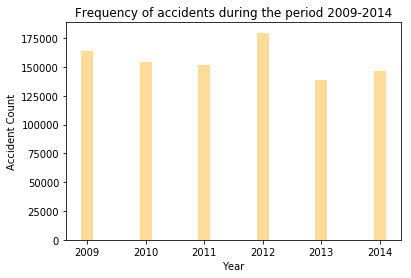

In [9]:
## Has accidents decreased over the years ?
accident_counts = [len(_yearly_data) for _yearly_data in _data]

## How has accidents varied over the years
fig = plt.figure()
plt.bar(years, accident_counts, align='center', alpha=0.4, color = 'orange', width=0.2)
#plt.bar(y_pos, performance, 

plt.xlabel('Year')
plt.ylabel('Accident Count')
plt.title('Frequency of accidents during the period 2009-2014')

plt.show()

There have been an increase in the number of accidents in 2012, and then in 2013 the number of accidents have gone down.

ToDo: Why has there been an increase in 2012?



1) Light_Conditions

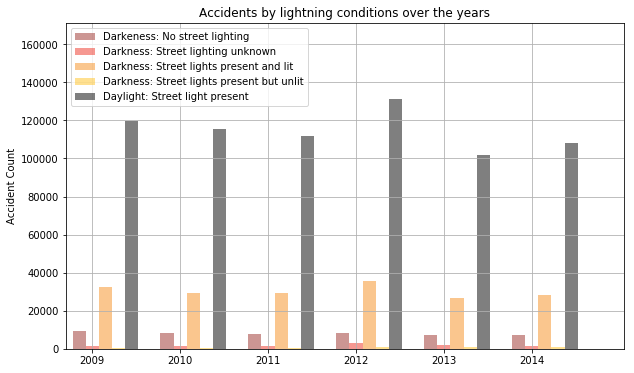

In [10]:
light_conditions = ['Darkeness: No street lighting','Darkness: Street lighting unknown',
                    'Darkness: Street lights present and lit', 'Darkness: Street lights present but unlit',
                    'Daylight: Street light present']

light_conditions_grouped_by_year = [_data[i].groupby(['Light_Conditions']).size().tolist() for i in range(len(_data))]
ys = [[row[j] for row in light_conditions_grouped_by_year] for j in range(5)]

items = pd.unique(data.Light_Conditions).tolist()
width = 0.15
pos = list(range(len(years))) 

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(pos,ys[0], width, alpha=0.5, color='#9b2f29', label=items[0]) 
plt.bar([p + width for p in pos], ys[1],width, alpha=0.5, color='#EE3224', label=items[1]) 
plt.bar([p + width*2 for p in pos], ys[2], width, alpha=0.5, color='#F78F1E', label=items[2]) 
plt.bar([p + width*3 for p in pos], ys[3], width, alpha=0.5, color='#FFC222', label=items[3]) 
plt.bar([p + width*4 for p in pos], ys[4], width, alpha=0.5, color='#000000', label=items[4]) 

ax.set_ylabel('Accident Count')
ax.set_title('Accidents by lightning conditions over the years')
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(years)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*8)
plt.ylim([0, max(ys[0] +  ys[1] + ys[2] + ys[3] + ys[4]) + 40000])

# Adding the legend and showing the plot
plt.legend(light_conditions, loc='upper left')
plt.grid()
plt.show()


Most accidents occur during the daytime - Probably lighting conditions at night are good in the UK. And, traffic might be lesser at night - Probably that is why accidents are less at nights. Chances that lights aren't lit if they're present are highly unlikely - This could be the reason why the fourth bar in every year is short. 

The trends have mostly remained same across the years. However in 2012, the number of death happens to be more and most of them seems to have happened during the day.

##### Which areas have the most number of accidents - Let's create some new variables 



In [11]:
#Locating points in the map
# top 200 location of accidents
import operator

acc_grouped = data.groupby(['co-ord_imprecise']).size().sort_values(ascending=False).to_dict()
top_200_accident_locations = sorted(acc_grouped.items(), key=operator.itemgetter(1))[len(acc_grouped)-100:len(acc_grouped)]

top_accident_coordinates = [(float(point[0][0]),float(point[0][1])) for point in top_200_accident_locations]


import folium
m = folium.Map(width=950,height=570,location=data["co-ordinates"][0], zoom_start=6)

#locationlist = data1["co-ordinates"].tolist()[0:10]
for point in top_accident_coordinates:
    try:
        folium.Marker(point).add_to(m)
    except:
        pass

m


In [12]:
grouped_accidents = [_data[i].groupby(['city']).size().sort_values(ascending=False).to_dict() for i in range(len(years))]

import operator
sorted_grouped_accidents = [sorted(d.items(), key=operator.itemgetter(1))[len(d) - 11:len(d)] for d in grouped_accidents]

format_changer = [dict(t) for t in sorted_grouped_accidents]
[t.pop("Unknown", None) for t in format_changer]



[163554, 154414, 151474, 179715, 138660, 146322]

In [13]:
# Weather conditions - Under what weather conditions do most number of accidents occur
#weather_conditions = ['Fine without high winds', 'Other', 'Raining without high winds',
#       'Snowing without high winds', 'Fine with high winds',
#       'Raining with high winds', 'Unknown', 'Snowing with high winds',
#       'Fog or mist', nan]

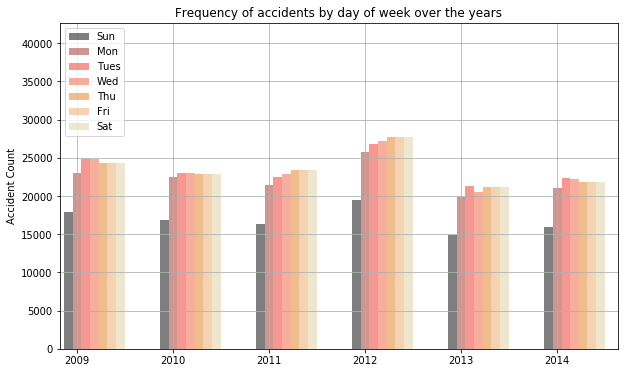

In [14]:
# what day of the week do m ost accidents occur?
day_of_week_grouped = list(data.groupby(['Day_of_Week']).size())


items = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']

day_of_week_grouped_by_year = [_data[i].groupby(['Day_of_Week']).size().tolist() for i in range(len(_data))]
ys = [[row[j] for row in day_of_week_grouped_by_year] for j in range(7)]

#items = pd.unique(data.Light_Conditions).tolist()
width = 0.09
pos = list(range(len(years))) 

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(pos,ys[0], width, alpha=0.5, color='#000000', label=items[0]) 
plt.bar([p + width for p in pos], ys[1],width, alpha=0.5, color='#9b2f29', label=items[1]) 
plt.bar([p + width*2 for p in pos], ys[2], width, alpha=0.5, color='#EE3224', label=items[2]) 
plt.bar([p + width*3 for p in pos], ys[3], width, alpha=0.5, color='#f25e3c', label=items[3]) 
plt.bar([p + width*4 for p in pos], ys[4], width, alpha=0.5, color='#e27c1b', label=items[4]) 
plt.bar([p + width*5 for p in pos], ys[4], width, alpha=0.5, color='#eaa869', label=items[5]) 
plt.bar([p + width*6 for p in pos], ys[4], width, alpha=0.5, color='#e0cfa3', label=items[6]) 


ax.set_ylabel('Accident Count')
ax.set_title('Frequency of accidents by day of week over the years')
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(years)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*8)
plt.ylim([0, max(ys[0] +  ys[1] + ys[2] + ys[3] + ys[4]) + 15000])

# Adding the legend and showing the plot
plt.legend(items, loc='upper left')
plt.grid()
plt.show()




Fridays have the maximum number of accidents

[101233, 133541, 140622, 140578, 141220, 153143, 123802]


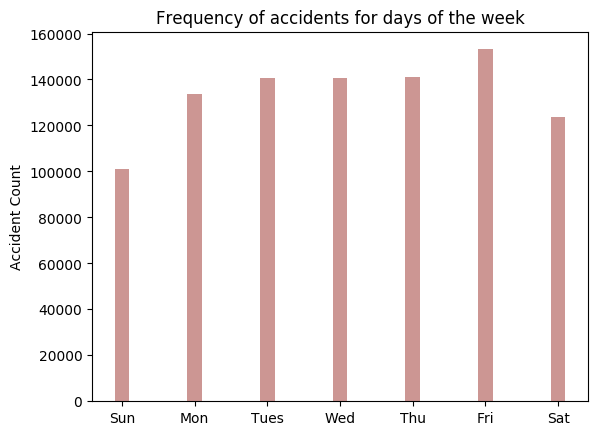

In [15]:
print(day_of_week_grouped)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat')
y_pos = np.arange(len(objects))
performance = day_of_week_grouped
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='#9b2f29', width=0.2)
plt.xticks(y_pos, objects)
plt.ylabel('Accident Count')
plt.title('Frequency of accidents for days of the week')
 
plt.show()


In [16]:
# What time of the day does most accidents occur

data['Hour'] = data['Time'].apply(lambda x : str(x).split(":")[0])
hour_grouped = data.groupby(['Hour']).size()                                
hour_grouped.sort_values(ascending=False)


Hour
17     83676
16     76377
15     72837
08     68873
18     65199
14     57102
13     56767
12     55543
11     49231
19     47720
09     47202
10     42689
07     39738
20     34473
21     27234
22     23450
23     18210
06     16790
00     13512
01      9969
02      7788
05      7776
03      6654
04      5279
nan       50
dtype: int64

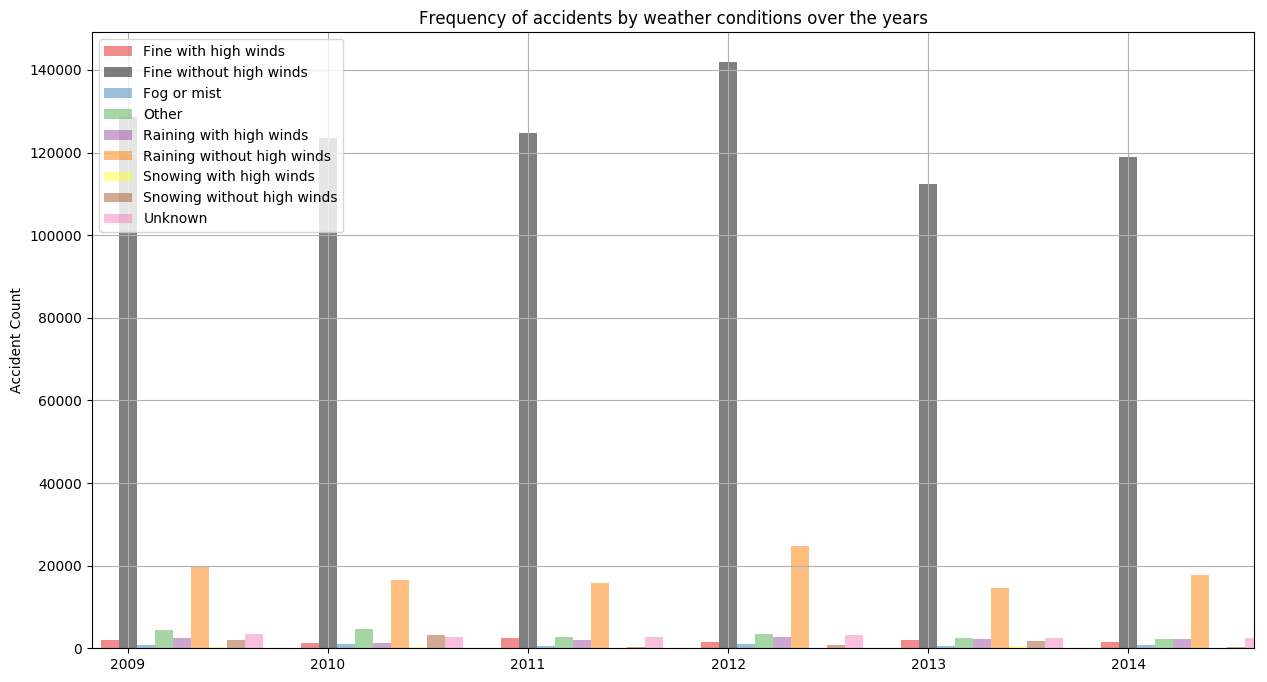

In [17]:
items = ['Fine with high winds', 'Fine without high winds', 'Fog or mist', 'Other', 'Raining with high winds', 
         'Raining without high winds', 'Snowing with high winds', 'Snowing without high winds', 'Unknown']                       

weather_grouped_by_year = [_data[i].groupby(['Weather_Conditions']).size().tolist() for i in range(len(_data))]
ys = [[row[j] for row in weather_grouped_by_year] for j in range(9)]

#items = pd.unique(data.Light_Conditions).tolist()
width = 0.09
pos = list(range(len(years))) 

import pylab

fig, ax = plt.subplots(figsize=(15,8))
plt.bar(pos,ys[0], width, alpha=0.5, color='#e41a1c', label=items[0]) 
plt.bar([p + width for p in pos], ys[1],width, alpha=0.5, color='#000000', label=items[1]) 
plt.bar([p + width*2 for p in pos], ys[2], width, alpha=0.5, color='#377eb8', label=items[2]) 
plt.bar([p + width*3 for p in pos], ys[3], width, alpha=0.5, color='#4daf4a', label=items[3]) 
plt.bar([p + width*4 for p in pos], ys[4], width, alpha=0.5, color='#984ea3', label=items[4]) 
plt.bar([p + width*5 for p in pos], ys[5], width, alpha=0.5, color='#ff7f00', label=items[5]) 
plt.bar([p + width*6 for p in pos], ys[6], width, alpha=0.5, color='#ffff33', label=items[6])
plt.bar([p + width*7 for p in pos], ys[7], width, alpha=0.5, color='#a65628', label=items[7])
plt.bar([p + width*8 for p in pos], ys[8], width, alpha=0.5, color='#f781bf', label=items[8])



ax.set_ylabel('Accident Count')
ax.set_title('Frequency of accidents by weather conditions over the years')
ax.set_xticks([p + 1 * width for p in pos])

#ax.set_yticks([40000, 80000, 120000, 140000, 160000])

# Set the labels for the x ticks
ax.set_xticklabels(years)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*8)
#plt.ylim([0, 600 ])
# pylab.ylim([0,1000])

# Adding the legend and showing the plot
plt.legend(items, loc='upper left')
plt.grid()
plt.show()




Most accidents occur from 3pm-6pm

In [18]:
# has this trend changed over the years
data1['Hour'] = data1['Time'].apply(lambda x : str(x).split(":")[0])
hour_grouped = data1.groupby(['Hour']).size()    


_data[0].groupby(['Weather_Conditions']).size()

Weather_Conditions
Fine with high winds            2097
Fine without high winds       128526
Fog or mist                      788
Other                           4502
Raining with high winds         2386
Raining without high winds     19682
Snowing with high winds          254
Snowing without high winds      1916
Unknown                         3352
dtype: int64